In [199]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd

import pymc as pm

print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v5.25.1


In [200]:
az.style.use("arviz-darkgrid")

RANDOM_SEED = 58
rng = np.random.default_rng(RANDOM_SEED)


def standardize(series):
    """Standardize a pandas series"""
    return (series - series.mean()) / series.std()

In [201]:
N = 100

df = pd.DataFrame({
    'X1': rng.normal(loc=2.5, scale=1.0, size=N),
    'X2': rng.normal(loc=5, scale=1.0, size=N)
})
intercept, b0, b1, b2 = 15, 5, 0.5, 10
df = df.assign(
    Y = intercept + b0*df['X1'] + b1*(df['X1']**2) + b2*df['X2'] + rng.normal(0, 1, N)
)
print(intercept, b0, b1, b2)
print(df)

15 5 0.5 10
          X1        X2           Y
0   1.924933  5.997904   85.177885
1   2.592064  6.934557  101.458873
2   0.388229  4.051483   57.867236
3   1.102954  3.958024   61.472657
4   1.743468  5.519616   80.161537
..       ...       ...         ...
95  2.880386  4.622980   80.556722
96  3.089063  4.029740   75.731557
97  1.933098  4.838882   74.523104
98  2.140077  4.500692   73.434650
99  3.015233  4.144363   76.132527

[100 rows x 3 columns]


Text(0.5, 0, 'X2')

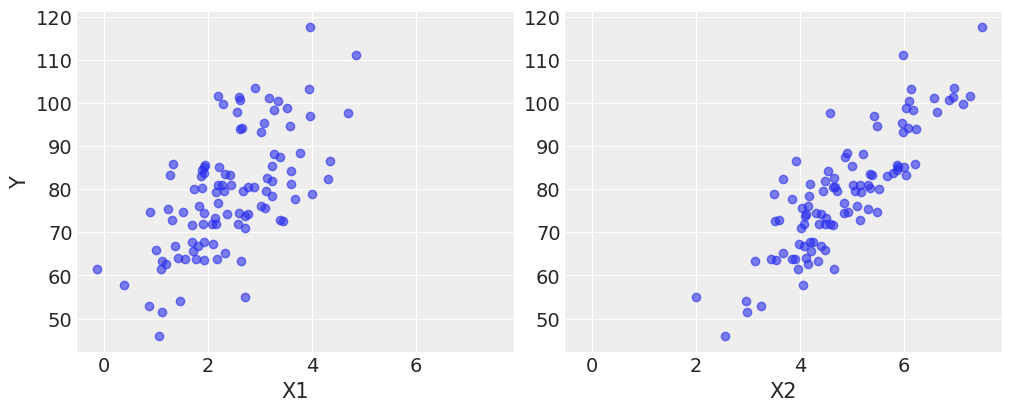

In [202]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(10, 4))
axes[0].scatter(df['X1'], df['Y'], alpha=0.6)
axes[1].scatter(df['X2'], df['Y'], alpha=0.6)
axes[0].set_ylabel("Y")
axes[0].set_xlabel("X1")
axes[1].set_xlabel("X2")

In [203]:
with pm.Model() as model_1:
    inter = pm.Uniform('inter', lower=-20, upper=20)
    beta = pm.Normal('beta', mu=[6, 2], sigma=[2, 1])
    sigma = pm.HalfNormal('sigma', sigma=1)

    mu = inter + beta[0]*df['X1'] + beta[1]*pow(df['X1'], 2)

    y = pm.Normal('y', mu=mu, sigma=sigma, observed=df['Y'])

    trace0 = pm.sample(idata_kwargs={'log_likelihood': True}, draws=2000, return_inferencedata=True, random_seed=rng)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [inter, beta, sigma]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.


In [204]:
az.summary(trace0, var_names=['inter', 'beta', 'sigma'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
inter,19.815,0.181,19.486,20.000,0.002,0.003,3967.0,3321.0,1.0
beta[0],25.220,1.302,22.788,27.668,0.023,0.017,3297.0,3872.0,1.0
beta[1],-1.172,0.405,-1.918,-0.407,0.007,0.005,3373.0,3717.0,1.0
sigma,10.663,0.483,9.725,11.509,0.007,0.005,4274.0,4801.0,1.0


array([[<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>],
       [<Axes: title={'center': 'inter'}>,
        <Axes: title={'center': 'inter'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

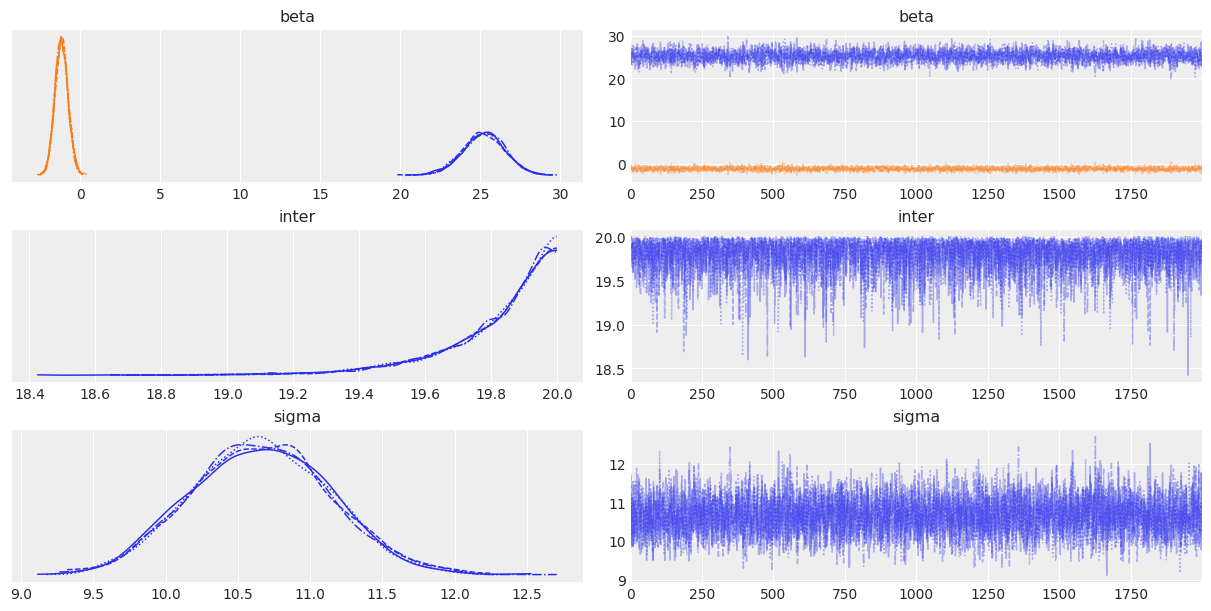

In [205]:
az.plot_trace(trace0)
# Posterior Distribution for Model 1

Sampling: [y]


Output()

<Axes: xlabel='y'>

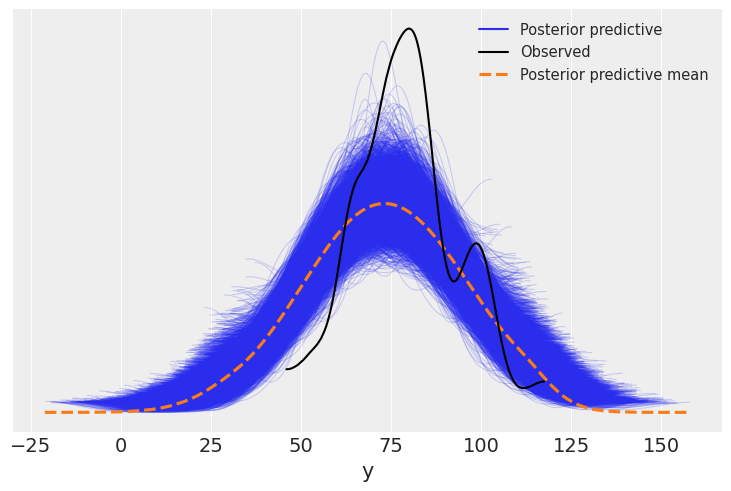

In [206]:
with model_1:
    pm.sample_posterior_predictive(trace0, extend_inferencedata=True, random_seed=rng)
az.plot_ppc(trace0)
# Posterior Predictive Check for Model 1

In [224]:
with pm.Model() as model_2:
    inter = pm.Uniform('inter', lower=-5, upper=5)
    beta = pm.Normal('beta', mu=4, sigma=1)
    sigma = pm.HalfNormal('sigma', sigma=1)

    mu = inter + beta*pow(df['X2'], 2)

    y = pm.Normal('y', mu=mu, sigma=sigma, observed=df['Y'])

    prior1 = pm.sample_prior_predictive(draws=50, random_seed=rng)
    trace1 = pm.sample(idata_kwargs={'log_likelihood': True}, draws=2000, return_inferencedata=True, random_seed=rng)

Sampling: [beta, inter, sigma, y]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [inter, beta, sigma]


Output()

/Users/biplobmac/Code/Seminar_Bayesian_Model_Averaging/.venv/lib/python3.11/site-packages/pymc/step_methods/hmc/quadpotential.py:316: RuntimeWarning: overflow encountered in dot
  return 0.5 * np.dot(x, v_out)


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 1 seconds.


In [225]:
az.summary(trace1, var_names=['inter', 'beta', 'sigma'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
inter,4.791,0.211,4.411,5.000,0.003,0.004,4690.0,3051.0,1.0
beta,2.709,0.048,2.622,2.800,0.001,0.001,4925.0,4929.0,1.0
sigma,12.740,0.436,11.911,13.547,0.006,0.005,5518.0,5098.0,1.0


array([[<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>],
       [<Axes: title={'center': 'inter'}>,
        <Axes: title={'center': 'inter'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

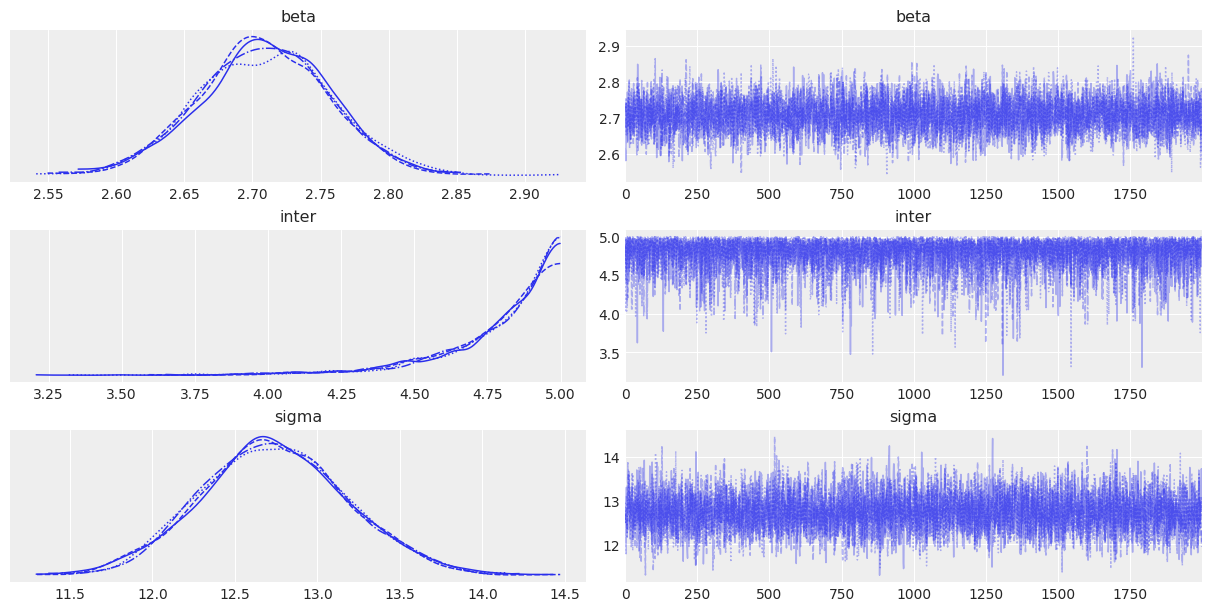

In [226]:
az.plot_trace(trace1)
# Posterior Distribution for Model 2

Sampling: [y]


Output()

<Axes: xlabel='y'>

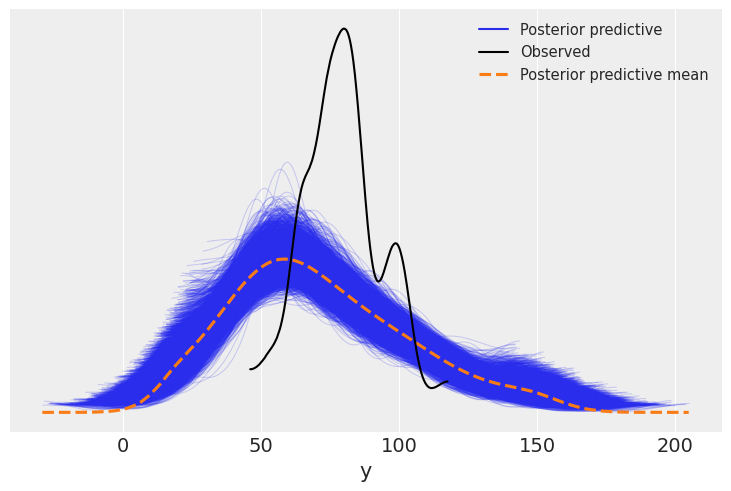

In [227]:
with model_2:
    pm.sample_posterior_predictive(trace1, extend_inferencedata=True, random_seed=rng)
az.plot_ppc(trace1)
# Posterior Predictive Check for Model 2

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

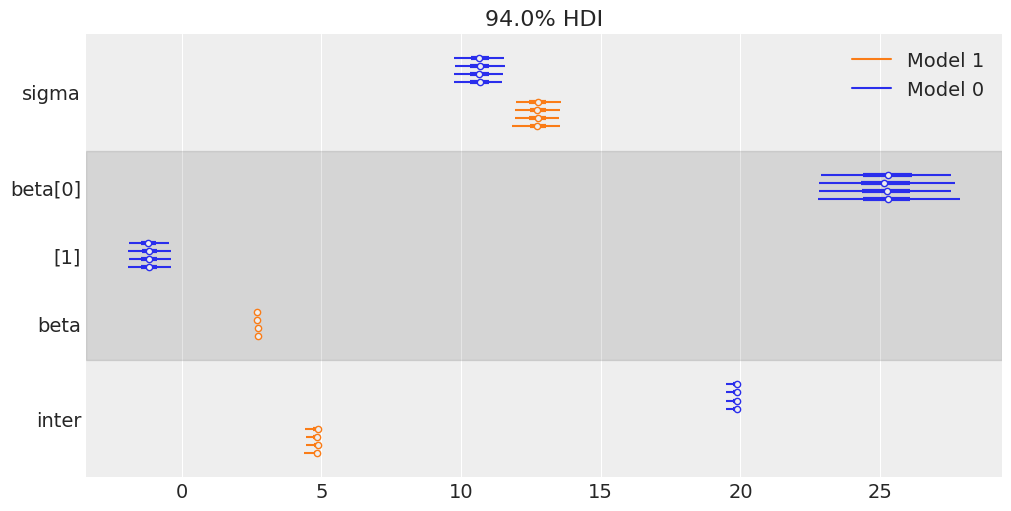

In [228]:
traces = [trace0, trace1]
az.plot_forest(traces, figsize=(10,5))

In [229]:
model_dict = dict(zip(['only_x1', 'only_x2'], traces))
comp = az.compare(model_dict, method='stacking')
comp

# Weight of models using epdlc approximation using loo

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
only_x1,0,-437.215029,4.067061,0.000000,0.793265,14.471335,0.000000,False,log
only_x2,1,-479.287431,4.381598,42.072402,0.206735,15.021783,17.668276,False,log


<Axes: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_loo (log)', ylabel='ranked models'>

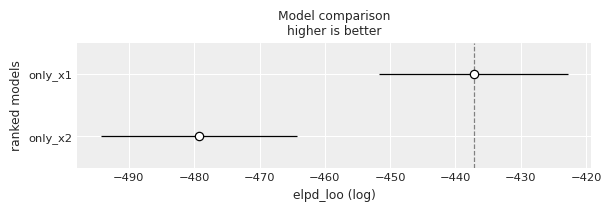

In [230]:
az.plot_compare(comp)

In [231]:
ppc_w = az.weight_predictions(
    [model_dict[name] for name in comp.index],
    weights=comp.weight,
)
ppc_w

Inference data with groups:
	> posterior_predictive
	> observed_data

<Axes: >

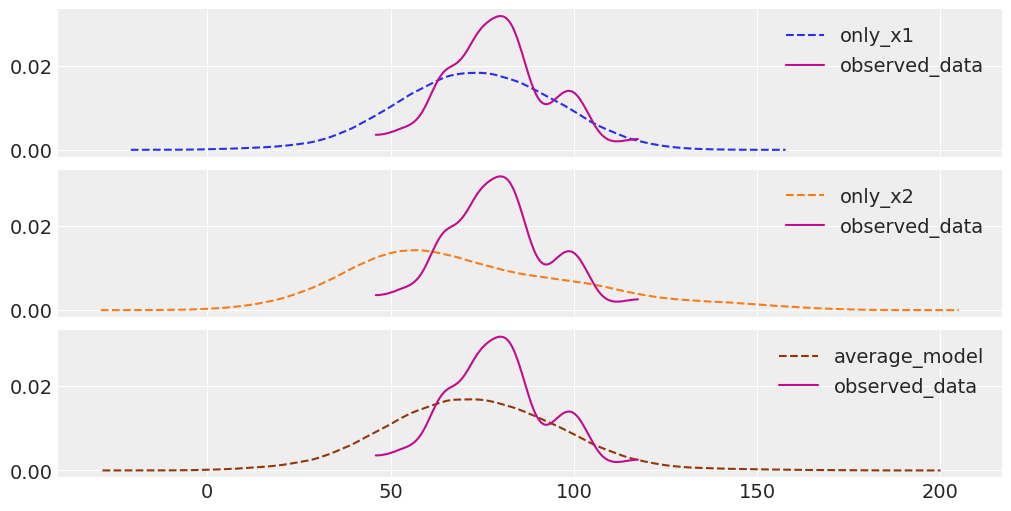

In [232]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(10,5))
az.plot_kde(
    trace0.posterior_predictive["y"].values,
    plot_kwargs={"color": "C0", "linestyle": "--"},
    label="only_x1",
    ax=ax1
)
az.plot_kde(
    trace0.observed_data['y'].values,
    plot_kwargs={"color": "C3", "linestyle": '-'},
    label="observed_data",
    ax=ax1
)
az.plot_kde(
    trace1.posterior_predictive["y"].values,
    plot_kwargs={"color": "C1", "linestyle": "--"},
    label="only_x2",
    ax=ax2
)
az.plot_kde(
    trace0.observed_data['y'].values,
    plot_kwargs={"color": "C3", "linestyle": '-'},
    label="observed_data",
    ax=ax2
)
az.plot_kde(
    ppc_w.posterior_predictive["y"].values,
    plot_kwargs={"color": "C4", "linestyle": '--'},
    label="average_model",
    ax=ax3
)
az.plot_kde(
    trace0.observed_data['y'].values,
    plot_kwargs={"color": "C3", "linestyle": '-'},
    label="observed_data",
    ax=ax3
)

#All models posterior prediction comparison